&nbsp;

# 프로젝트：모든 장르 간 편향성 측정해 보기

&nbsp;

실습 과정에서 영화 시놉시스 코퍼스를 가지고 영화 구분과 영화 장르 간에 내재된 편향성을 측정하는 작업을 진행하였다.

이번에는 모든 장르에 대해 영화 구분과의 편향성 정도를 측정해 보도록 한다. 

대부분의 과정은 학습／실습 부분에서 진행한 내용을 참고하여 진행 하도록 하겠다.

&nbsp;

### 0. 라이브러리 버전 확인

<hr>

In [2]:
import os
import numpy as np
import seaborn as sns;
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

## WEAT score
from numpy import dot
from numpy.linalg import norm

## PCA
from sklearn.decomposition import PCA

## pretrained
from gensim.models import KeyedVectors

## tokenize & embedding
from konlpy.tag import Okt
from gensim.models import Word2Vec

## TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

import konlpy
import gensim
import sklearn
import seaborn
print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.5.2
4.1.2
1.0
0.11.2


&nbsp;

### 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

<hr>

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다. (개봉된 영화 중 일부 포함) 

데이터 확인을 위해 synopsis.txt의 일부를 읽어보자.

In [3]:
with open(os.getenv("HOME")+"/aiffel/weat/synopsis.txt", "r") as file:
    for i in range(20):
        print(file.readline(), end="")

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 `tokenized` 라는 변수명으로 저장해보자.

데이터를 확인 해 보니, 영어나 특수문자등을 제거하기 위해 정규표현식 등을 사용할 필요는 없이,

명사 추출하는 과정에서 자연스럽게 제거가 된 것 같다.

~~~
엽기적인 살인사건이 발생한 장소를 관광하는 투어팀. 그 팀에서 관광객들은 살인사건과 관련하여 히스테리컬한 반응을 보이는데 과연 이들의 정체는? (Tourists see whrer a murder take place. They respond hysterically to the murder…what are they?)
    
['엽기',  '살인',  '사건',  '발생',  '장소',  '관광',  '투어',  '팀',  '그',  '팀',  '관광객',  '살인',  '사건',  '관련',  '히스리',  '컬',  '반응',  '과연',  '이',  '정체']
~~~

다만, corpus(말뭉치)에서 일반적으로 불용어라고 생각하는 것들이 많이 보여서,

불용어 제거를 적용하여 토큰화를 다시 진행하도록 하겠다.

~~예시로 출력 한 문장에서 '살인', '사건', '팀' 이라는 단어가 반복되니, 중복제거도 수행하도록 하겠다.~~

In [4]:
stopwords = ["아", "휴", "아이구", "아이쿠", "아이고", "어", "나", "우리", "저희", "따라", "의해", "을", "를", "에", "의", "가", "으로", "로", "에게", "뿐이다", "의거하여", "근거하여", "입각하여", "기준으로", "예하면", "예를 들면", "예를 들자면", "저", "소인", "소생", "저희", "지말고", "하지마", "하지마라", "다른", "물론", "또한", "그리고", "비길수 없다", "해서는 안된다", "뿐만 아니라", "만이 아니다", "만은 아니다", "막론하고", "관계없이", "그치지 않다", "그러나", "그런데", "하지만", "든간에", "논하지 않다", "따지지 않다", "설사", "비록", "더라도", "아니면", "만 못하다", "하는 편이 낫다", "불문하고", "향하여", "향해서", "향하다", "쪽으로", "틈타", "이용하여", "타다", "오르다", "제외하고", "이 외에", "이 밖에", "하여야", "비로소", "한다면 몰라도", "외에도", "이곳", "여기", "부터", "기점으로", "따라서", "할 생각이다", "하려고하다", "이리하여", "그리하여", "그렇게 함으로써", "하지만", "일때", "할때", "앞에서", "중에서", "보는데서", "으로써", "로써", "까지", "해야한다", "일것이다", "반드시", "할줄알다", "할수있다", "할수있어", "임에 틀림없다", "한다면", "등", "등등", "제", "겨우", "단지", "다만", "할뿐", "딩동", "댕그", "대해서", "대하여", "대하면", "훨씬", "얼마나", "얼마만큼", "얼마큼", "남짓", "여", "얼마간", "약간", "다소", "좀", "조금", "다수", "몇", "얼마", "지만", "하물며", "또한", "그러나", "그렇지만", "하지만", "이외에도", "대해 말하자면", "뿐이다", "다음에", "반대로", "반대로 말하자면", "이와 반대로", "바꾸어서 말하면", "바꾸어서 한다면", "만약", "그렇지않으면", "까악", "툭", "딱", "삐걱거리다", "보드득", "비걱거리다", "꽈당", "응당", "해야한다", "에 가서", "각", "각각", "여러분", "각종", "각자", "제각기", "하도록하다", "와", "과", "그러므로", "그래서", "고로", "한 까닭에", "하기 때문에", "거니와", "이지만", "대하여", "관하여", "관한", "과연", "실로", "아니나다를가", "생각한대로", "진짜로", "한적이있다", "하곤하였다", "하", "하하", "허허", "아하", "거바", "와", "오", "왜", "어째서", "무엇때문에", "어찌", "하겠는가", "무슨", "어디", "어느곳", "더군다나", "하물며", "더욱이는", "어느때", "언제", "야", "이봐", "어이", "여보시오", "흐흐", "흥", "휴", "헉헉", "헐떡헐떡", "영차", "여차", "어기여차", "끙끙", "아야", "앗", "아야", "콸콸", "졸졸", "좍좍", "뚝뚝", "주룩주룩", "솨", "우르르", "그래도", "또", "그리고", "바꾸어말하면", "바꾸어말하자면", "혹은", "혹시", "답다", "및", "그에 따르는", "때가 되어", "즉", "지든지", "설령", "가령", "하더라도", "할지라도", "일지라도", "지든지", "몇", "거의", "하마터면", "인젠", "이젠", "된바에야", "된이상", "만큼 어찌됏든", "그위에", "게다가", "점에서 보아", "비추어 보아", "고려하면", "하게될것이다", "일것이다", "비교적", "좀", "보다더", "비하면", "시키다", "하게하다", "할만하다", "의해서", "연이서", "이어서", "잇따라", "뒤따라", "뒤이어", "결국", "의지하여", "기대여", "통하여", "자마자", "더욱더", "불구하고", "얼마든지", "마음대로", "주저하지 않고", "곧", "즉시", "바로", "당장", "하자마자", "밖에 안된다", "하면된다", "그래", "그렇지", "요컨대", "다시 말하자면", "바꿔 말하면", "즉", "구체적으로", "말하자면", "시작", "시작하여", "시초에", "이상", "허", "헉", "허걱", "바와같이", "해도좋다", "해도된다", "게다가", "더구나", "하물며", "와르르", "팍", "퍽", "펄렁", "동안", "이래", "하고있었다", "이었다", "에서", "로부터", "까지", "예하면", "했어요", "해요", "함께", "같이", "더불어", "마저", "마저도", "양자", "모두", "습니다", "가까스로", "하려고하다", "즈음하여", "다른", "다른 방면으로", "해봐요", "습니까", "했어요", "말할것도 없고", "무릎쓰고", "개의치않고", "하는것만 못하다", "하는것이 낫다", "매", "매번", "들", "모", "어느것", "모든", "어느", "로써", "갖고말하자면", "어디", "어느쪽", "어느것", "어느해", "어느 년도", "라 해도", "언젠가", "어떤것", "어느것", "저기", "저쪽", "저것", "그때", "그럼", "그러면", "요만한걸", "그래", "그때", "저것만큼", "그저", "이르기까지", "할 줄 안다", "할 힘이 있다", "너", "너희", "당신", "어찌", "설마", "차라리", "할지언정", "할지라도", "할망정", "할지언정", "구토하다", "게우다", "토하다", "메쓰겁다", "옆사람", "사람", "퉤", "쳇", "의거하여", "근거하여", "의해", "따라", "힘입어", "그", "다음", "버금", "두번째로", "기타", "첫번째로", "나머지는", "그중에서", "견지에서", "형식으로 쓰여", "입장에서", "위해서", "단지", "의해되다", "하도록시키다", "뿐만아니라", "반대로", "전후", "전자", "앞의것", "잠시", "잠깐", "하면서", "그렇지만", "다음에", "그러한즉", "그런즉", "남들", "아무거나", "어찌하든지", "같다", "비슷하다", "예컨대", "이럴정도로", "어떻게", "만약", "만일", "위에서","서술한바와같이", "인 듯하다", "하지 않는다면", "만약에", "무엇", "무슨", "어느", "어떤", "아래윗", "조차", "한데", "그럼에도 불구하고", "여전히", "심지어", "까지도", "조차도", "하지 않도록", "않기 위하여", "때", "시각", "무렵", "시간", "동안", "어때", "어떠한", "하여금", "네", "예", "우선", "누구", "누가 알겠는가", "아무도", "줄은모른다", "줄은 몰랏다", "하는 김에", "겸사겸사", "하는바", "그런 까닭에", "한 이유는", "그러니", "그러니까", "때문에", "그", "그녀","너희", "그들", "너희들", "타인", "것", "것들", "너", "위하여", "위해", "공동으로", "동시에", "하기 위하여", "어찌하여", "무엇때문에", "붕붕", "윙윙", "나", "우리", "엉엉", "휘익", "윙윙", "오호", "아하", "어쨋든", "만 못하다","하기보다는", "차라리", "하는 편이 낫다", "흐흐", "놀라다", "상대적으로 말하자면", "마치", "아니라면", "쉿", "그렇지 않으면", "그렇지 않다면", "안 그러면", "아니었다면", "하든지", "아니면", "이라면", "좋아", "알았어", "하는것도", "그만이다", "어쩔수 없다", "하나", "일", "일반적으로", "일단", "한켠으로는", "오자마자", "이렇게되면", "이와같다면", "전부", "한마디", "한항목", "근거로", "하기에", "아울러", "하지 않도록", "않기 위해서", "이르기까지", "이 되다", "로 인하여", "까닭으로", "이유만으로", "이로 인하여", "그래서", "이 때문에", "그러므로", "그런 까닭에", "알 수 있다", "결론을 낼 수 있다", "으로 인하여", "있다", "어떤것", "관계", "관계가 있다", "관련이 있다", "연관되다", "어떤것들", "에 대해", "이리하여", "그리하여", "여부", "하기보다는", "하느니", "하면 할수록", "운운", "이러이러하다", "하구나", "하도다", "다시말하면", "다음으로", "에 있다", "에 달려 있다", "우리", "우리들", "오히려", "하기는한데", "어떻게", "어떻해", "어찌됏어", "어때", "어째서", "본대로", "자", "이", "이쪽", "여기", "이것", "이번", "이렇게말하자면", "이런", "이러한", "이와 같은", "요만큼", "요만한 것", "얼마 안 되는 것", "이만큼", "이 정도의", "이렇게 많은 것", "이와 같다", "이때", "이렇구나", "것과 같이", "끼익", "삐걱", "따위", "와 같은 사람들", "부류의 사람들", "왜냐하면", "중의하나", "오직", "오로지", "에 한하다", "하기만 하면", "도착하다", "까지 미치다", "도달하다", "정도에 이르다", "할 지경이다", "결과에 이르다", "관해서는", "여러분", "하고 있다", "한 후", "혼자", "자기", "자기집", "자신", "우에 종합한것과같이", "총적으로 보면", "총적으로 말하면", "총적으로", "대로 하다", "으로서", "참", "그만이다", "할 따름이다", "쿵", "탕탕", "쾅쾅", "둥둥", "봐", "봐라", "아이야", "아니", "와아", "응", "아이", "참나", "년", "월", "일", "령", "영", "일", "이", "삼", "사", "오", "육", "륙", "칠", "팔", "구", "이천육", "이천칠", "이천팔", "이천구", "하나", "둘", "셋", "넷", "다섯", "여섯", "일곱", "여덟", "아홉", "령", "영"]

아래 코드블럭의 하단부에 불용어 제거 코드~~와 중복 제거 코드~~ 추가 외에는 동일하다.

> 중복제거 적용후 model.wv.most_similar() 단계에서, 결과 단어들이 완전히 이상해지는 것을 확인 할 수 있었다.

중복 제거는 사용하지 않도록 주석 처리 하였다.

In [5]:
# 약 15분정도 걸립니다.

file_path = os.getenv("HOME")+"/aiffel/weat/synopsis.txt"

okt = Okt()
tokenized = []

import mmap
def get_num_lines(file_path):
    fp = open(file_path, "r+")
    buf = mmap.mmap(fp.fileno(), 0)
    lines = 0
    while buf.readline():
        lines += 1
    return lines

with open(file_path, "r") as file:
    for line in tqdm(file, total=get_num_lines(file_path)):
        
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:    # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
                
        res = [word for word in res if not word in stopwords] ## 불용어 제거
        ##res = list(set(res))    ## 중복 제거
        tokenized.append(res)

print("슝~")

100%|██████████| 71156/71156 [11:37<00:00, 102.02it/s]

슝~


In [6]:
print(len(tokenized))


71156


이 정도만 진행하고 다음으로 넘어가자.

&nbsp;

### 2. 추출된 결과로 embedding model 만들기

<hr>

In [7]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [8]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8967552185058594),
 ('드라마', 0.8799618482589722),
 ('다큐멘터리', 0.860818088054657),
 ('소설', 0.8478189706802368),
 ('코미디', 0.8474732637405396),
 ('스토리', 0.8445879817008972),
 ('형식', 0.838748574256897),
 ('주제', 0.838631272315979),
 ('편의', 0.8374199271202087),
 ('영화로', 0.8365243673324585)]

In [9]:
model.wv.most_similar(positive=['사랑'])

[('시빌라', 0.7659137845039368),
 ('우정', 0.765322744846344),
 ('싹트기', 0.7563014626502991),
 ('이별', 0.7544040679931641),
 ('연인', 0.7473155856132507),
 ('아르튬', 0.7447000741958618),
 ('행복', 0.7391822338104248),
 ('고백', 0.7386739253997803),
 ('연애', 0.7366814017295837),
 ('감정', 0.7290429472923279)]

In [10]:
model.wv.most_similar(positive=['연극'])

[('영화감독', 0.925767719745636),
 ('시나리오', 0.9125866293907166),
 ('데뷔', 0.9034178256988525),
 ('배우', 0.8976595997810364),
 ('출연', 0.8964418768882751),
 ('개성', 0.8934891223907471),
 ('영감', 0.8926212787628174),
 ('캐스팅', 0.890487015247345),
 ('시대극', 0.8891528844833374),
 ('작가', 0.8848392963409424)]

&nbsp;

### 3. target, attribute 단어 셋 만들기

<hr>

WEAT score를 구할 때 단어 셋을 만들어주어야 한다.

targets_X, targets_Y, attribute_A, attribute_B 를 만들어주었던 것 처럼,

두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 한다.

여기서는 두 축을 영화 장르, 영화 구분 정보를 이용한다.

- 영화 구분

  + `synopsis_art.txt` : 예술영화

  + `synopsis_gen.txt` : 일반영화(상업영화)

  + 그 외는 `독립영화` 등으로 분류

&nbsp;

- 장르 구분

  + `synopsis_SF.txt: SF`

  + `synopsis_가족.txt: 가족`

  + `synopsis_공연.txt: 공연`

  + `synopsis_공포(호러).txt: 공포(호러)`

  + `synopsis_기타.txt: 기타`

  + `synopsis_다큐멘터리.txt: 다큐멘터리`

  + `synopsis_드라마.txt: 드라마`

  + `synopsis_멜로로맨스.txt: 멜로로맨스`

  + `synopsis_뮤지컬.txt: 뮤지컬`

  + `synopsis_미스터리.txt: 미스터리`

  + `synopsis_범죄.txt: 범죄`

  + `synopsis_사극.txt: 사극`

  + `synopsis_서부극(웨스턴).txt: 서부극(웨스턴)`

  + `synopsis_성인물(에로).txt: 성인물(에로)`

  + `synopsis_스릴러.txt: 스릴러`

  + `synopsis_애니메이션.txt: 애니메이션`

  + `synopsis_액션.txt: 액션`

  + `synopsis_어드벤처.txt: 어드벤처`

  + `synopsis_전쟁.txt: 전쟁`

  + `synopsis_코미디.txt: 코미디`

  + `synopsis_판타지.txt: 판타지`

이제 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 

드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보자.

즉 드라마 장르에는 예술영화적 성격이 강하고, 액션 장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이

워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것이다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 불러와서, 

위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당한다.

In [11]:
def read_token(file_name):

    file_path = os.getenv("HOME")+"/aiffel/weat/" + file_name
    
    okt = Okt()
    result = []
        
    with open(file_path, "r") as fread: 
        print(file_name, "파일을 읽습니다.")
        
        for line in tqdm(fread, total=get_num_lines(file_path)):
            
            tokenlist = okt.pos(line, stem=True, norm=True) 
            
            for word in tokenlist:
                if word[1] in ["Noun"]:
                    result.append((word[0]))
                    
        result = res = [word for word in result if not word in stopwords] ## 불용어 제거       
        
    return " ".join(result)

print("슝~")

슝~


In [12]:
art_txt = "synopsis_art.txt"
gen_txt = "synopsis_gen.txt"

# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽습니다.


100%|██████████| 14435/14435 [01:55<00:00, 124.84it/s]


synopsis_gen.txt 파일을 읽습니다.


100%|██████████| 48116/48116 [09:54<00:00, 80.89it/s] 


&nbsp;

WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요하다.

예를 들면 예술영화라는 개념을 가장 잘 대표하는 단어들을 `art_txt` 를 처리해서 만든 `art` 라는

단어 리스트에서부터 골라내야 하는데, 이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만

보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋을 것이다.

어떤 개념을 나타내는 단어를 선정하는 방법으로 꼭 정해진 방법이 있는 것은 아니다.

그러나 이번 경우에는 예술영화, 일반영화라는 영화 구분별로 시놉시스를 모아 데이터를 구성했으니,

예술영화를 잘 대표하는 단어란, 예술영화 시놉시스에는 자주 나타나지만

그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것이다.

이런 것과 비슷한 개념의 단어 분석 방식 중, 여기서는 코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 

다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하는,

단어 셋 구성을 위해 TF-IDF방식을 사용한다. (꼭 TF-IDF 방식이 최선이라는 의미는 아님.)

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 40945)


In [14]:
print(vectorizer.vocabulary_['영화'])

23882


In [15]:
print(vectorizer.get_feature_names()[23887])

영화로


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


&nbsp;

In [16]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print("예술영화를 대표하는 단어들:")
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=", ")

print("\n")
    
print("일반영화를 대표하는 단어들:")
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=", ")

예술영화를 대표하는 단어들:
사랑, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 엄마, 여자, 대한, 서로, 다시, 아들, 소녀, 아내, 사이, 영화제, 세계, 사실, 점점, 남편, 감독, 여행, 인생, 발견, 순간, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 청년, 한국, 가지, 상처, 할머니, 목숨, 희망, 계획, 매력, 프랑스, 사회, 제안, 만남, 거리, 이유, 파리, 

일반영화를 대표하는 단어들:
영화제, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 가족, 아버지, 마을, 엄마, 아들, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 소녀, 사이, 애니메이션, 때문, 여성, 죽음, 점점, 인간, 생활, 한편, 결혼, 상황, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 이후, 조직, 회사, 보고, 부산, 아빠, 부부, 일본, 문제, 처음, 그것, 독립, 운명, 감정, 음악, 경쟁, 

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있다. 

두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶으니, 단어가 서로 중복되지 않게 단어셋을 추출해야 한다.

우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출한다.

In [17]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): 
        target_art.append(w1_[i])
    if len(target_art) == n: 
        break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): 
        target_gen.append(w2_[i])
    if len(target_gen) == n: 
        break

추출한 단어를 확인해보자.

In [18]:
print(target_art)

['결심', '지금', '여인', '이름', '준비', '만난', '충격', '그린', '연인', '청년', '상처', '할머니', '목숨', '희망', '매력']


In [19]:
print(target_gen)

['서울', '애니메이션', '여성', '주인공', '대해', '연출', '다큐멘터리', '부문', '섹스', '의도', '정체', '조직', '회사', '보고', '부산']


&nbsp;

이제 장르별 대표 단어를 추출해보자. 

드라마 장르와 액션 장르를 다루어 보려고 할 때, 드라마와 액션 단 2개의 장르만 고려하기보다는

여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것이다.

In [20]:
genre_txt = [
    "synopsis_SF.txt", "synopsis_family.txt", "synopsis_show.txt", 
    "synopsis_horror.txt", "synopsis_etc.txt", "synopsis_documentary.txt", 
    "synopsis_drama.txt", "synopsis_romance.txt", "synopsis_musical.txt", 
    "synopsis_mystery.txt", "synopsis_crime.txt", "synopsis_historical.txt", 
    "synopsis_western.txt", "synopsis_adult.txt", "synopsis_thriller.txt", 
    "synopsis_animation.txt", "synopsis_action.txt", "synopsis_adventure.txt", 
    "synopsis_war.txt", "synopsis_comedy.txt",  "synopsis_fantasy.txt"]

genre_name = [
    "SF", "가족", "공연", 
    "공포(호러)", "기타", "다큐멘터리", 
    "드라마", "멜로로맨스", "뮤지컬", 
    "미스터리", "범죄", "사극", 
    "서부극(웨스턴)", "성인물(에로)", "스릴러", 
    "애니메이션", "액션", "어드벤처", 
    "전쟁", "코미디", "판타지"]

print("✔️")

✔️


In [21]:
genre = []
for i, file_name in enumerate(genre_txt, start=1):
    print("[", i, "／", len(genre_txt), "] ", end="")
    genre.append(read_token(file_name))
    
print("✔️")

[ 1 ／ 21 ] synopsis_SF.txt 파일을 읽습니다.


100%|██████████| 1023/1023 [00:11<00:00, 85.87it/s] 


[ 2 ／ 21 ] synopsis_family.txt 파일을 읽습니다.


100%|██████████| 422/422 [00:04<00:00, 91.68it/s] 


[ 3 ／ 21 ] synopsis_show.txt 파일을 읽습니다.


100%|██████████| 346/346 [00:04<00:00, 72.51it/s] 


[ 4 ／ 21 ] synopsis_horror.txt 파일을 읽습니다.


100%|██████████| 3088/3088 [00:33<00:00, 91.94it/s] 


[ 5 ／ 21 ] synopsis_etc.txt 파일을 읽습니다.


100%|██████████| 3687/3687 [00:29<00:00, 125.75it/s]


[ 6 ／ 21 ] synopsis_documentary.txt 파일을 읽습니다.


100%|██████████| 7147/7147 [01:31<00:00, 77.78it/s] 


[ 7 ／ 21 ] synopsis_drama.txt 파일을 읽습니다.


100%|██████████| 19229/19229 [03:43<00:00, 86.00it/s] 


[ 8 ／ 21 ] synopsis_romance.txt 파일을 읽습니다.


100%|██████████| 5776/5776 [00:58<00:00, 97.96it/s] 


[ 9 ／ 21 ] synopsis_musical.txt 파일을 읽습니다.


100%|██████████| 170/170 [00:01<00:00, 86.92it/s] 


[ 10 ／ 21 ] synopsis_mystery.txt 파일을 읽습니다.


100%|██████████| 1078/1078 [00:08<00:00, 122.91it/s]


[ 11 ／ 21 ] synopsis_crime.txt 파일을 읽습니다.


100%|██████████| 1694/1694 [00:16<00:00, 105.16it/s]


[ 12 ／ 21 ] synopsis_historical.txt 파일을 읽습니다.


100%|██████████| 239/239 [00:01<00:00, 132.36it/s]


[ 13 ／ 21 ] synopsis_western.txt 파일을 읽습니다.


100%|██████████| 48/48 [00:00<00:00, 79.44it/s] 


[ 14 ／ 21 ] synopsis_adult.txt 파일을 읽습니다.


100%|██████████| 1647/1647 [00:28<00:00, 58.75it/s] 


[ 15 ／ 21 ] synopsis_thriller.txt 파일을 읽습니다.


100%|██████████| 2265/2265 [00:24<00:00, 94.02it/s] 


[ 16 ／ 21 ] synopsis_animation.txt 파일을 읽습니다.


100%|██████████| 8779/8779 [01:13<00:00, 119.28it/s]


[ 17 ／ 21 ] synopsis_action.txt 파일을 읽습니다.


100%|██████████| 5860/5860 [01:01<00:00, 95.09it/s] 


[ 18 ／ 21 ] synopsis_adventure.txt 파일을 읽습니다.


100%|██████████| 535/535 [00:05<00:00, 95.56it/s] 


[ 19 ／ 21 ] synopsis_war.txt 파일을 읽습니다.


100%|██████████| 387/387 [00:04<00:00, 81.69it/s] 


[ 20 ／ 21 ] synopsis_comedy.txt 파일을 읽습니다.


100%|██████████| 4635/4635 [00:59<00:00, 77.97it/s] 


[ 21 ／ 21 ] synopsis_fantasy.txt 파일을 읽습니다.


100%|██████████| 801/801 [00:06<00:00, 118.20it/s]


✔️


In [22]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42054)


장르별 대표단어를 일부 확인해 보자.

In [23]:
import warnings
warnings.filterwarnings("ignore")

m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []

for i in range(len(w)):
    print(genre_name[i], end=": ")
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=", ")
        j += 1
    attributes.append(attr)
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 세계, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 
가족: 엄마, 아빠, 가족, 영화제, 친구, 아주르, 아버지, 아들, 마을, 국제, 낙타, 할머니, 씨제이, 동구, 사랑, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 
공포(호러): 친구, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 영화, 사실, 소녀, 살인, 이야기, 
기타: 영화제, 국제, 서울, 단편, 영화, 이야기, 남자, 사랑, 뉴미디어, 페스티벌, 여자, 대한, 독립, 친구, 작품, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 이야기, 대한, 감독, 서울, 세계, 통해, 여성, 가족, 한국, 작품, 
드라마: 영화제, 사랑, 영화, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 가족, 단편, 서울, 대한, 아들, 
멜로로맨스: 사랑, 남편, 남자, 여자, 친구, 섹스, 마음, 결혼, 서로, 아내, 부부, 엄마, 아버지, 사실, 영화, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 음악, 충무로, 모차르트, 영화, 토스카, 니웨, 카바, 영화제, 바흐, 페뷔스, 프롤, 모도, 
미스터리: 사건, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 민혁, 사실, 의문, 미스터리, 형사, 
범죄: 사건, 경찰, 범죄, 조직, 살인, 마약, 형사, 남자, 살해, 수사, 발견, 한길수, 범인, 계획, 은행, 
사극: 조선, 신기전, 사랑, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 개릿, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 
성인물(에로): 남편, 마사지, 섹스, 영화, 정사, 남자, 여자, 유부녀, 마음, 사랑, 에피소드, 그린, 아내, 다시, 자위, 
스릴러: 

결과를 통해서 약간의 문제점을 발견할 수 있는데, 같은 단어가 여러 장르에 걸쳐 나타나는 것이다.

대표단어를 알맞게 선정했다고 할 수 있을까？

의문과 별도로, 결과만 놓고 봤을때 선정된 단어들이 충분히 일반적으로 대표성을 가지는 단어들이다.

대표성은 굳이 1:1로 비교해보자면 떨어질지도 모르지만, 다른 장르에서 동일한 대표단어가 존재한다는 이유로

그것을 삭제 하는것은, 해당 장르에서 대표하는 단어라고 나온 결과를 또 무시하는게 아닐까…？

중복되는 단어들을 제거하는 것이, 대표단어를 더 정확히 선정했다고 할 수 있을까…？

예를 들어서, "사랑" 이란 단어가 곳곳에 보이는데, 이걸 다른 장르들의 대표단어에서 제외할 것을 생각해보면,

대표성을 높게 반영하는 요소로 "멜로로맨스" 장르에만 남겨두고 다른 곳에서 제외 한다고 하면,

얼핏 맞는것 같아 보일 수 있지만, 과연 그것이 합리적인 판단이라는 생각이 들지 않는다.

만약, 그러한 방법으로 다큐멘터리나 기타 등에서 "영화제" 라는 단어를 제외하게 된다면,

"드라마" 장르에서도 제 1순위가 "사랑" 이란 단어가 된다. 그렇게 된다면

"멜로로맨스" 장르와 "드라마" 의 장르에서 사랑을 남겨야 하는건 멜로로맨스 일까？

그렇다고 하더라도, "드라마" 장르에서 "사랑"이라는 대표단어를 아예 없애버리는 것이 옳은 일일까？


확신은 없지만, 단어들은 어느정도 허용하고 넘어가야 할 것 같다는 생각으로 마음이 기울어진다.

고민을 많이 해 본 결과, 이전에, 중복 제거를 사용했다가 주석처리 했던 때의 유사단어 결과가 떠올라서,

처음에는 복잡하더라도 중복 단어를 처리할까 생각하였으나, 이 프로젝트의 목표가 어느 정도의 결과물을 확인하기 위해

추론 하려는 프로젝트가 아니므로, 이 대표단어는 되도록 유지하고, WEAT Score 확인하는 방향으로 진행 하도록 하려 한다.

&nbsp;

### 4. WEAT score 계산과 시각화

<hr>

이제 WEAT_score를 구해보도록 하자.

traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있다.

target_X 는 art, target_Y 는 gen으로 고정하고,

attribute_A, attribute_B를 바꿔가면서 구해보도록 하겠다.

구한 결과를 21 $\times$ 21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아보자.

&nbsp;

#### WEAT score 계산에 필요한 함수 정의

<hr>

1. 두 벡터의 유사도를 측정하기 위한 cosine similarity 


$$ cos(θ) = {i⋅j \over ∣∣i∣∣∣∣j∣∣} $$


- $cos(θ)=1$ : 두 벡터의 방향이 똑같을 때

- $cos(θ)=0$ : 두 벡터가 직교할 때

- $cos(θ)=−1$ : 두 벡터의 방향이 반대일 때

cosine similarity는 -1에서 1을 가질 수 있으며 두 벡터의 방향이 얼마나 유사한지를 나타내게 된다.

In [24]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

&nbsp;

2. $s(w,A,B)$ 식의 정의.


$$ s(w,A,B) = mean_{a∈A}cos(\overrightarrow{w}, \overrightarrow{a}) - mean_{b∈B}cos(\overrightarrow{w}, \overrightarrow{b}) $$


- target에 있는 단어 $w$ 가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정.

- 즉, $s(w,A,B)$ 는 개별 단어 $w$ 가 개념축 A-B에 대해 가지는 편향성을 계산한 값이 된다.

- 이 편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 $w$ 는 A-B 개념축에 대해 편향성을 가진다는 뜻이다.

In [25]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

&nbsp;

3. WEAT score 정의.


$$ mean_{x∈X}s(x,A,B) − mean_{y∈Y}s(y,A,B) \over std_{w∈X∪Y}s(w,A,B) $$


 - 분자 부분은 target X, Y에 속하는 각 단어 $x$, $y$ 들이 개념축 A-B에 대해 가지는 편향성을 각각 평균 내서 뺀 차이.
 
 - 즉, X, Y 각각에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가<br>
 뚜렷이 차이 날수록, 이 WEAT score 식의 분자값의 절댓값은 커진다.
 
 - 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT score

In [26]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

&nbsp;

이제 WEAT score를 구해보고, 이를 시각화 해보자.

In [27]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])    ## X：art
Y = np.array([model.wv[word] for word in target_gen])    ## Y：general

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

&nbsp;

PCA를 통해 5차원이었던 벡터를 2차원으로 줄여 그림을 그려보는것도 해보자.

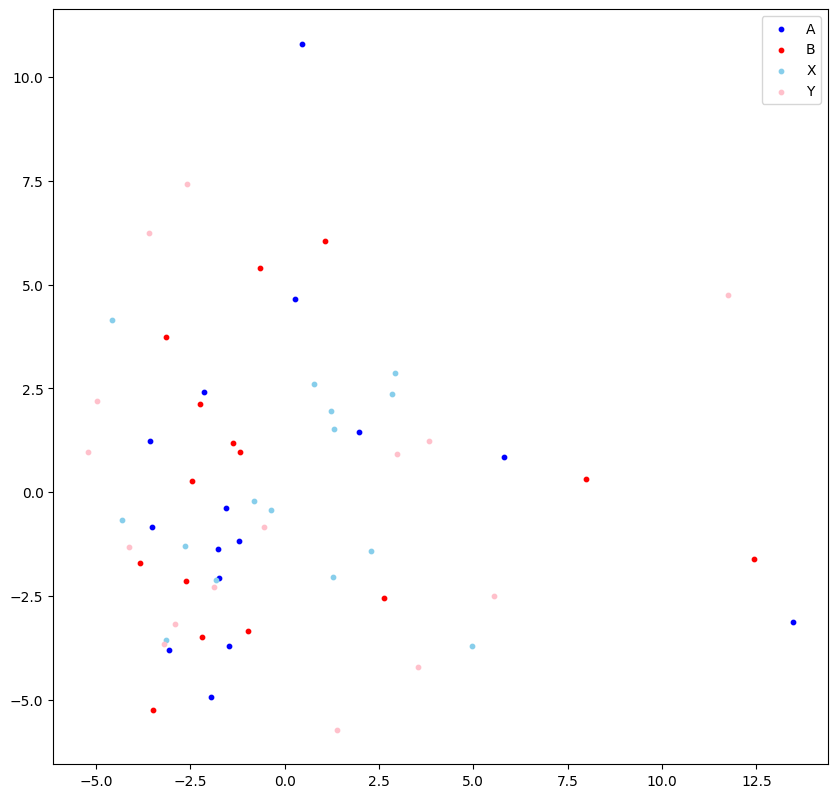

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
ax.scatter(pc_A[:,0],pc_A[:,1], s=10, c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], s=10, c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], s=10, c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], s=10, c='pink', label='Y')
ax.legend(loc='upper right', fontsize = 10);

plt.show()

파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현된 것을

확인해 볼 수 있을지 한번 시각화 해 보았는데, 여러 장르를 사용하다보니 구별이 쉽지 않다.

&nbsp;

In [29]:
ref_val = 1

for i in range(len(genre_name)-1):
#     print()
#     print("●", genre_name[i])
#     print("─" * 64)
    for j in range(i+1, len(genre_name)):
        if (abs(matrix[i][j]) >= ref_val):
            print(genre_name[i], "：", genre_name[j], round(matrix[i][j], 3))
    print("─" * 64)

────────────────────────────────────────────────────────────────
가족 ： 뮤지컬 1.09
가족 ： 애니메이션 1.069
────────────────────────────────────────────────────────────────
공연 ： 뮤지컬 1.034
────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────
기타 ： 드라마 -1.135
기타 ： 어드벤처 -1.041
기타 ： 코미디 -1.041
────────────────────────────────────────────────────────────────
다큐멘터리 ： 드라마 -1.067
다큐멘터리 ： 어드벤처 -1.166
다큐멘터리 ： 코미디 -1.023
────────────────────────────────────────────────────────────────
드라마 ： 뮤지컬 1.216
드라마 ： 애니메이션 1.093
────────────────────────────────────────────────────────────────
멜로로맨스 ： 뮤지컬 1.032
────────────────────────────────────────────────────────────────
뮤지컬 ： 어드벤처 -1.126
뮤지컬 ： 코미디 -1.127
────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────
────────────────────────────────────────────────────────────────
─────────────────────────────────────────────

- WEAT score 가 1.14 이상, -1.14 이하의 경우를 해석해 보면 다음과 같다.<br><br>

   + ① 예술영화와 일반영화, 그리고 「기타」, 「드라마」 영화의 WEAT score 의 의미를 해석해보면<br>
   예술영화는 드라마, 일반영화는 기타 장르와 가깝다고 볼 수 있다.<br>
   부호가 마이너스 이므로 사람의 편향과 반대라는 것을 알 수 있다.<br><br>
      
   + ② 예술영화와 일반영화, 그리고 「다큐멘터리」, 「어드벤쳐」 영화의 WEAT score 의 의미를 해석해보면<br>
   예술영화는 어드벤쳐, 일반영화는 다큐멘터리와 가깝다고 볼 수 있다.<br>
   부호가 마이너스 이므로 사람의 편향과 반대라는 것을 알 수 있다.<br><br>
      
   + ③ 예술영화와 일반영화, 그리고 「드라마」, 「뮤지컬」 영화의 WEAT score 의 의미를 해석해보면<br>
   예술영화는 드라마, 일반영화는 뮤지컬 장르와 가깝다고 볼 수 있다.<br><br>
   
   + ④ 예술영화와 일반영화, 그리고 「어드벤처」, 「판타지」 영화의 WEAT score 의 의미를 해석해보면<br>
   예술영화는 어드벤처, 일반영화는 판타지 장르와 가깝다고 볼 수 있다.<br><br>
  

&nbsp;

Heatmap 통해서도 시각화를 출력해보자.

<AxesSubplot:>

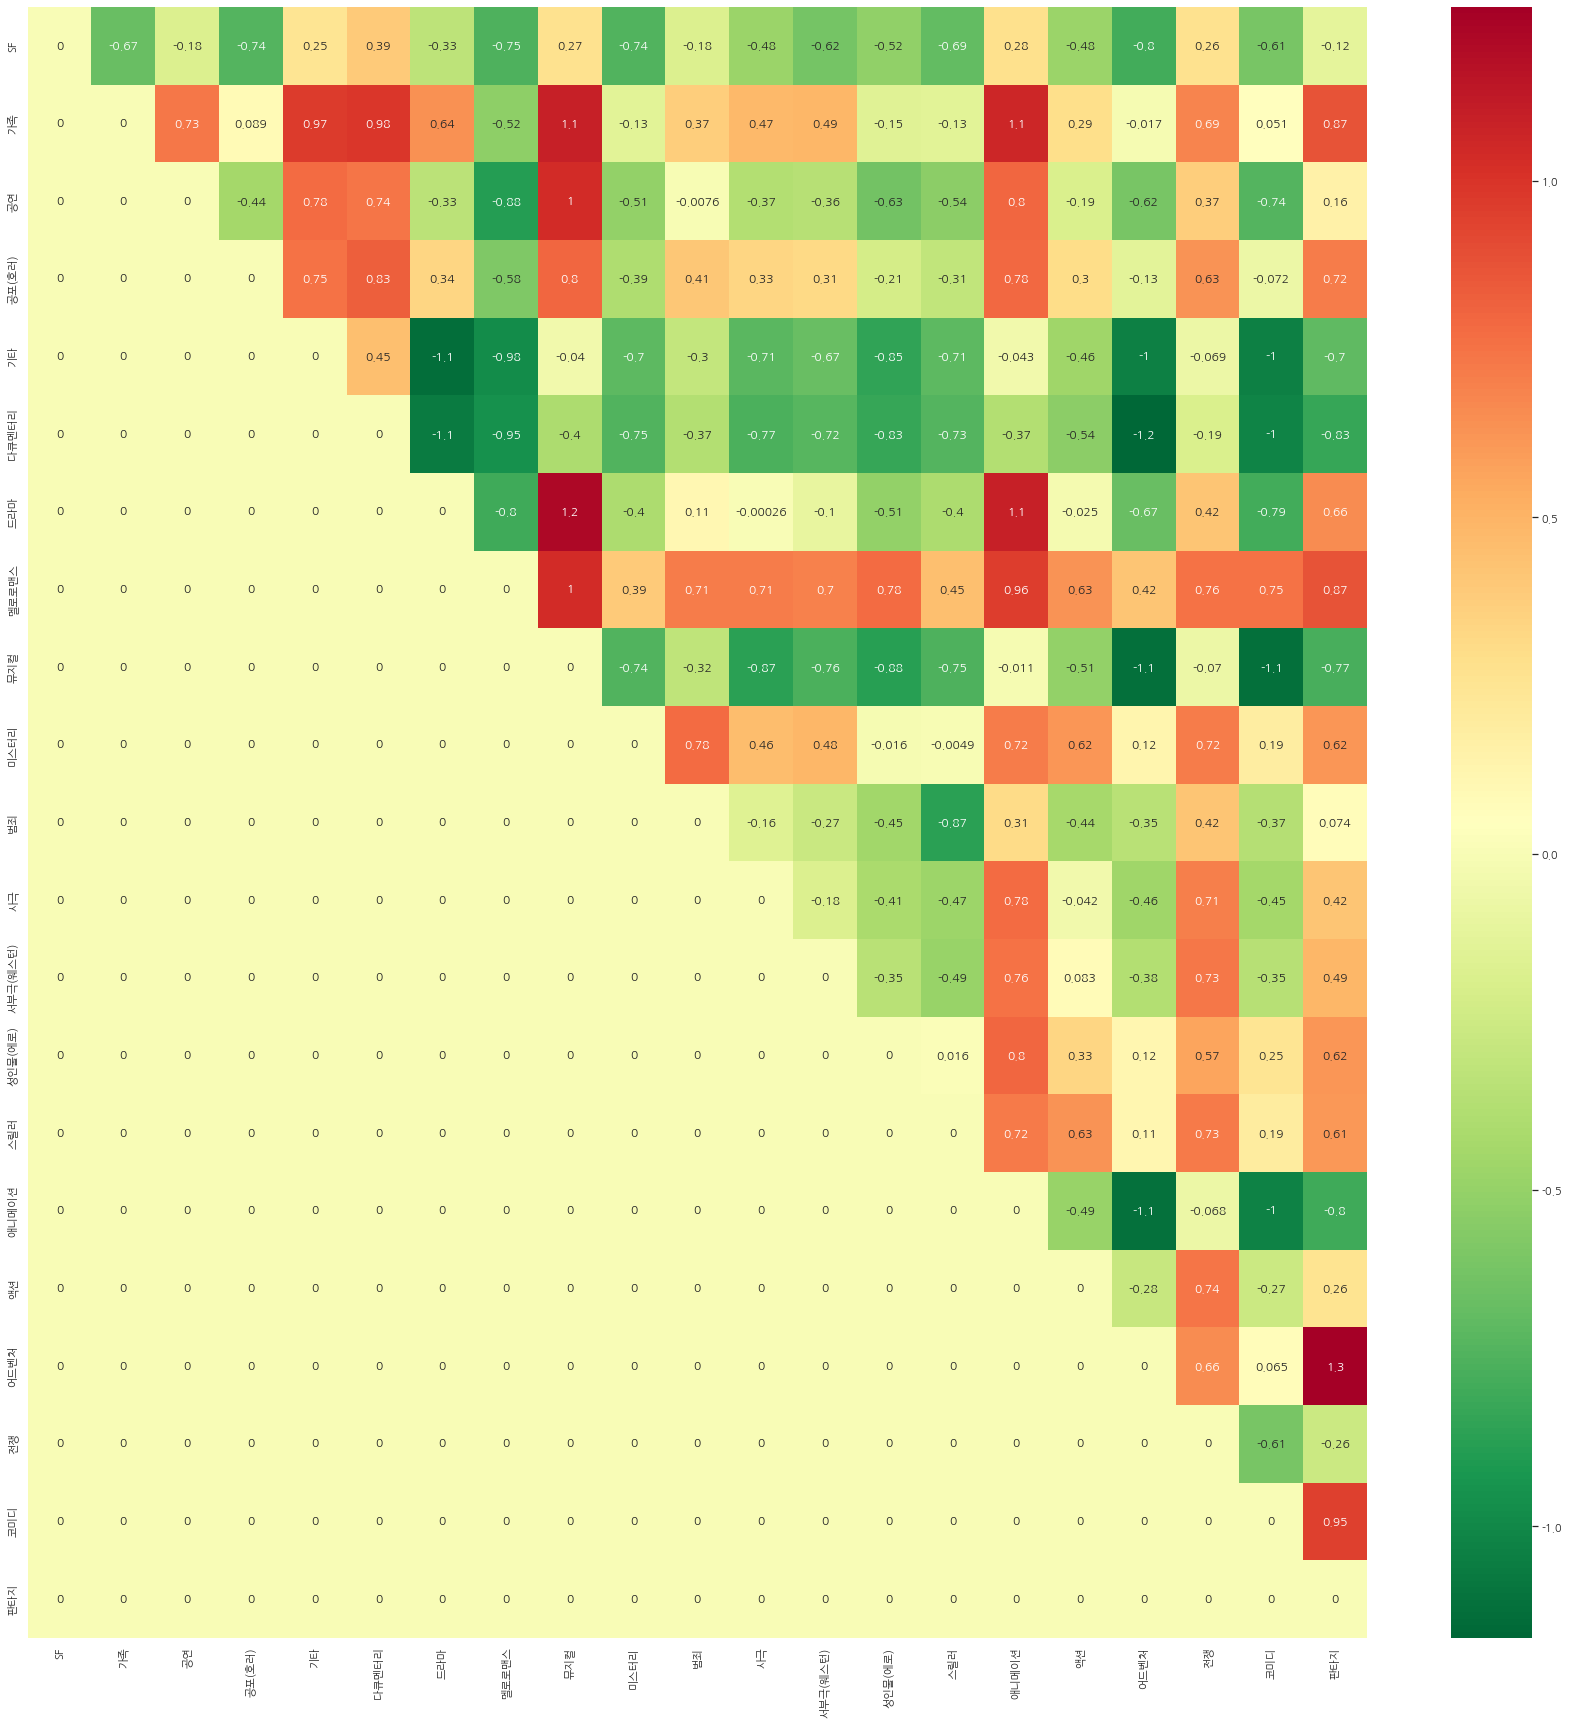

In [30]:
np.random.seed(0)
plt.figure(figsize = (30, 30))

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

적색은 편향이 같은 쪽이고, 녹색은 편향이 반대라고 볼 수 있다.

위의 Heatmap 에서, 앞서 WEAT score 그래프 해석 부분에서 다루었던 ①, ②, ③, ④ 항목의 위치를 아래에 표시하면 다음과 같다.

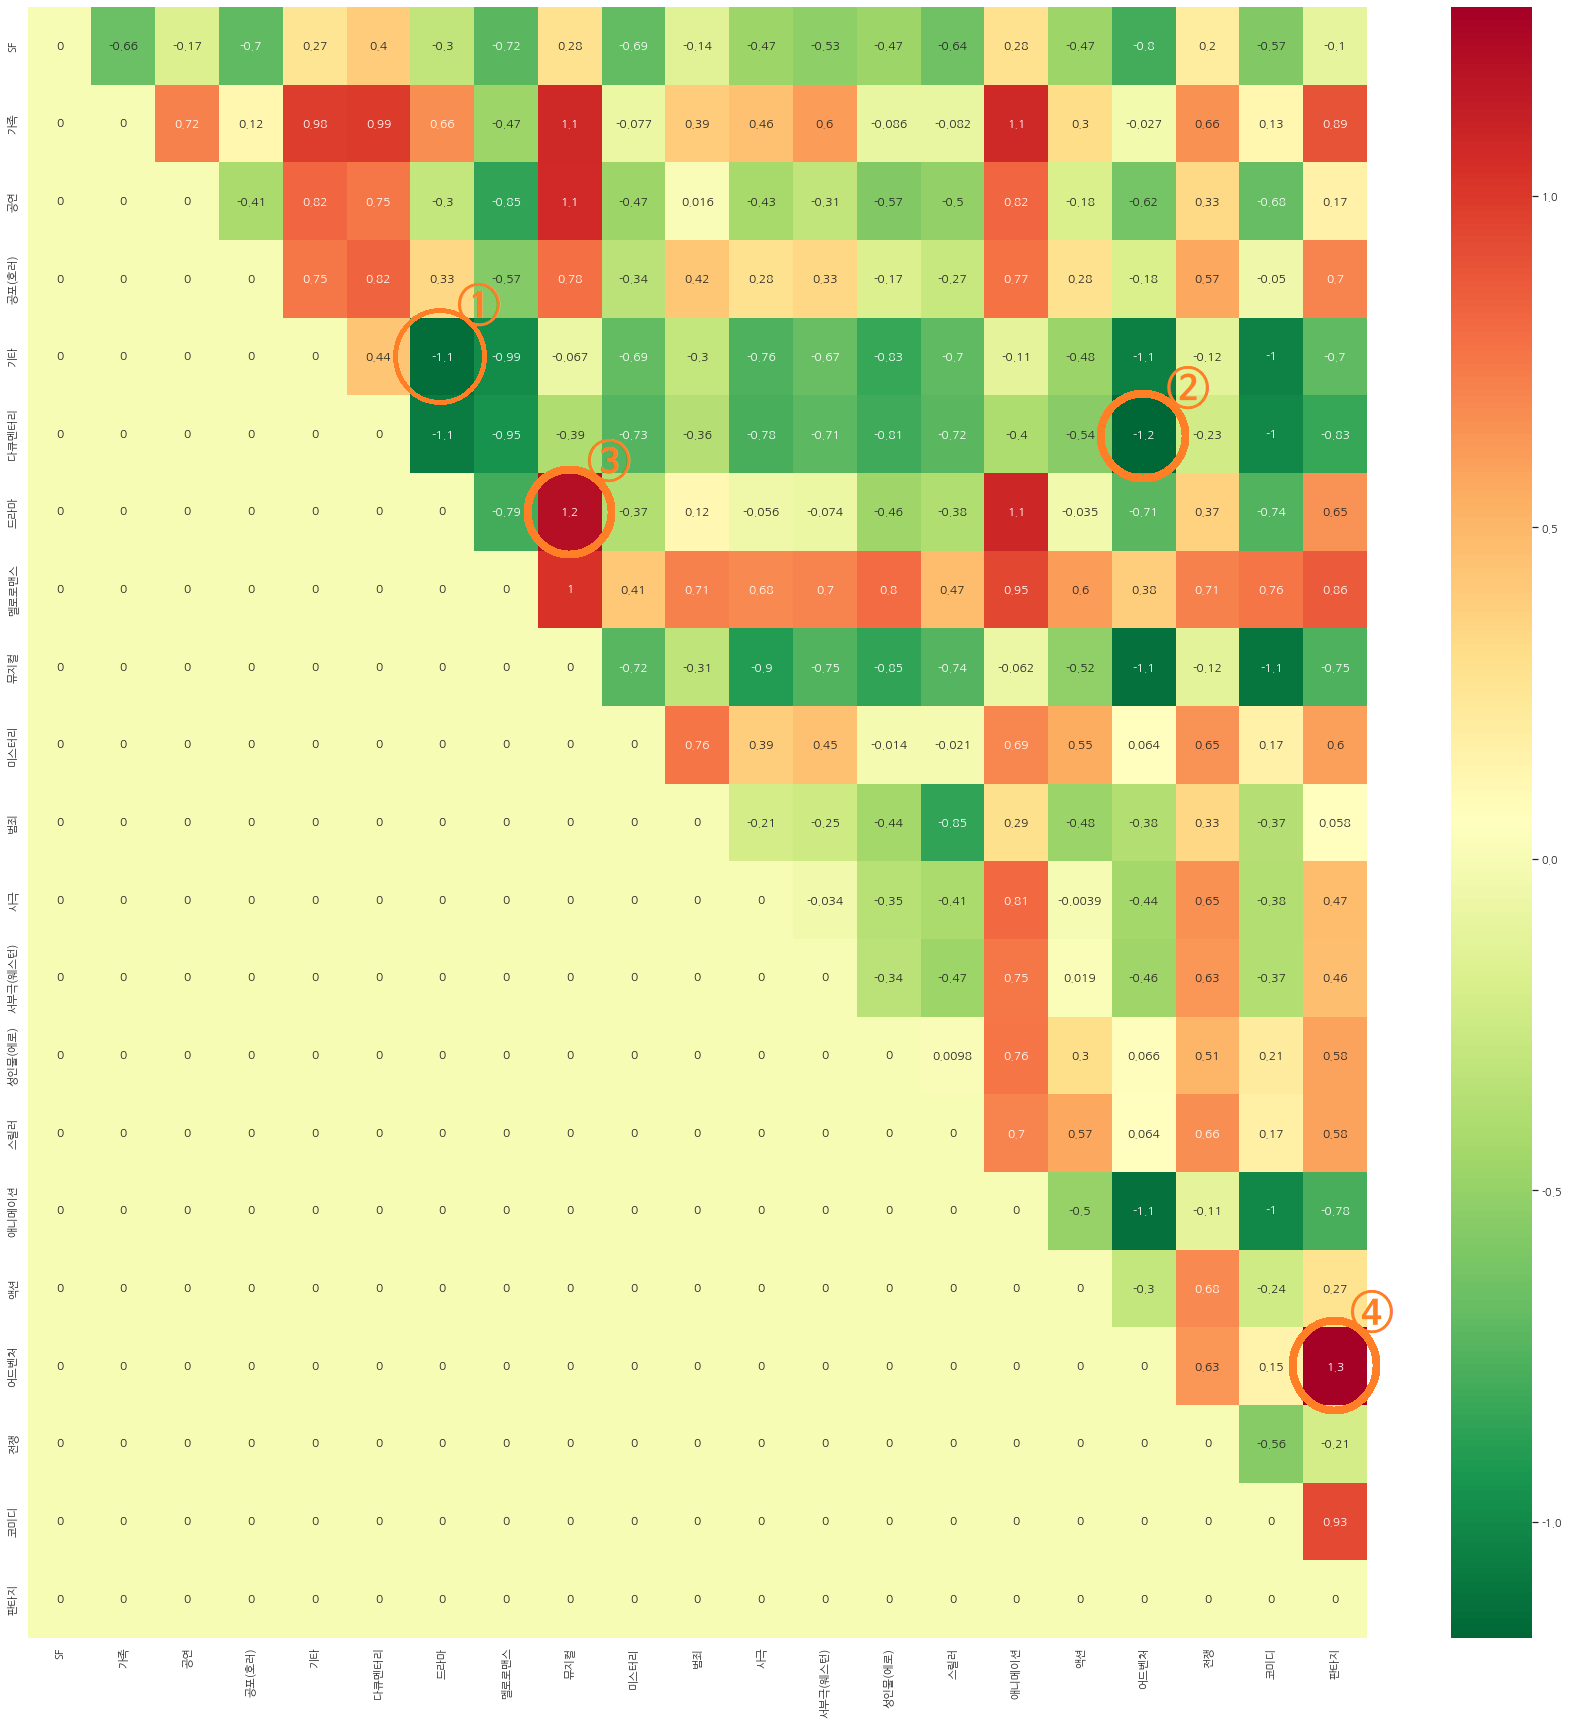

가로축과 세로축의 구성을 살펴 보면, 

전반적으로 확인해 보았을 때, 멜로로맨스 장르가 다른 장르들에 비하여, 예술영화에 가까운 편인 것을 알 수 있다.



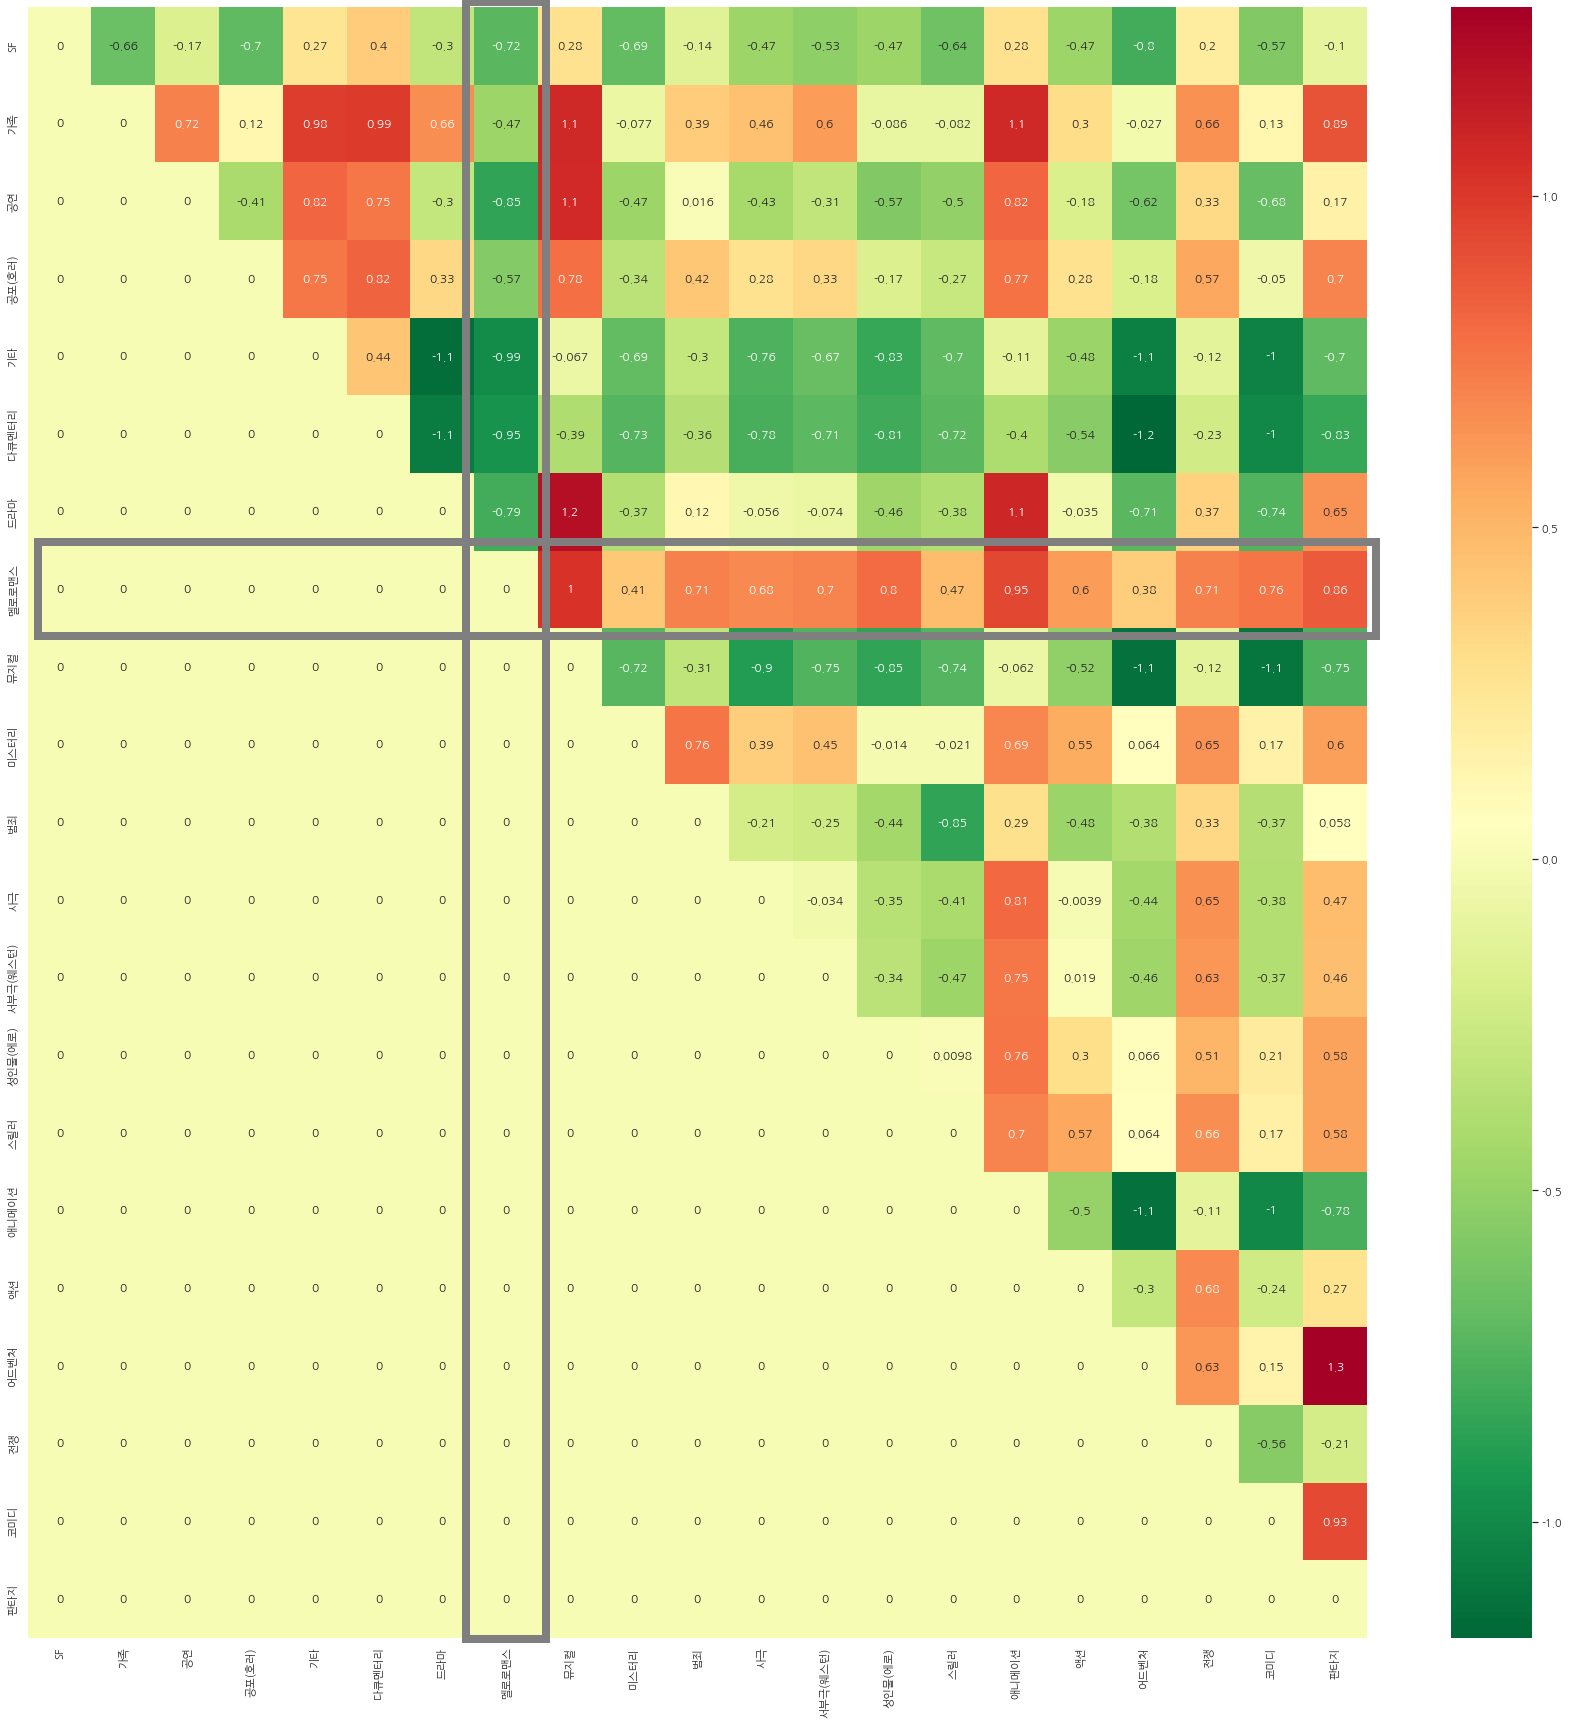

&nbsp;

중복제거의 경우 X, Y 에서 진행한 중복제거만큼 A, B 에서 중복 제거를 하지 않더라도 충분한 가치가 있다고 생각하였었고

그러한 이유로 A, B 에서는 중복제거를 진행하지 않고 해보겠다고 기록하고, 지금까지 쭈욱 실험을 진행하고 결과를 확인하였다.

여기에서 확인한 중복제거 결과를 통해 다른 교육생들과 이런저런 토론을 해 보았다.

중복제거를 한 교육생들의 결과와 중복제거를 하지 않은 여기서의 결과 차이가 크지 않을 거라는 예상을 확인 해 볼 수 있었다.

중복제거를 수행했을 경우의 결과를 간략하게 그래프를 통해 비교해 보자.

아래의 코드는 중복제거를 수행한다.

In [31]:
n = 10
attributes2 = []
w_ = []

for i in range(len(w)):
    ww_ = []
    for j in range(400):
        ww_.append(vectorizer.get_feature_names()[w[i][j][0]])
    w_.append(ww_)

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    etc = set()
    for k in range(len(w)):
        if k != i:
            etc.update(w_[k])    ## 원소 여러개 추가
    
    for j in range(len(w_[i])):
        if (w_[i][j] not in etc) and (w_[i][j] in model.wv):
            attr.append(w_[i][j])
            print(w_[i][j], end=', ')
        if len(attr) == n: 
            break 
            
    attributes2.append(attr)
    print()

SF: 스타크, 리플리, 켈빈, 컨트, 수퍼맨, 분파, 물체, 진화, 수트, 히노키, 
가족: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 
공연: 실황, 올레, 오텔로, 리골레토, 프레, 베르디, 비바, 콘서트, 백작부인, 반니, 
공포(호러): 악령, 분홍신, 캠핑, 정신병원, 레드, 에이미, 심령, 호러, 환영, 레스태트, 
기타: 뉴미디어, 메트로, 실험영화, 프라이드, 공사, 독도, 재연, 교통, 완섭, 사물, 
다큐멘터리: 투쟁, 인디다큐페스티발, 지난, 건축사, 세대, 공동체, 세월호, 산업, 교육, 혁명, 
드라마: 의지, 하루하루, 청춘, 데뷔, 교사, 여배우, 주목, 젊은이, 수정, 
멜로로맨스: 미연, 펜션, 수진, 하숙집, 주희, 준석, 처제, 호감, 정식, 정우, 
뮤지컬: 에스메랄다, 충무로, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 
미스터리: 방독면, 랭던, 몰카, 거미숲, 홈즈, 종섭, 한나, 승호, 동식, 민수현, 
범죄: 한길수, 파푸아, 금고, 마샨, 철중, 도미, 사기꾼, 맥베드, 와처스, 샤오창, 
사극: 신기전, 아가멤논, 루안, 하선, 윤서, 세자, 허균, 노준, 채선, 신재효, 
서부극(웨스턴): 벌린, 카우보이, 그레이프바인, 개릿, 무법자, 프린트, 마적, 태구, 버질, 랜던, 
성인물(에로): 유이, 성관계, 카즈야, 애무, 타케시, 타츠야, 토오루, 누나, 히로시, 사유리, 
스릴러: 영훈, 감금, 혜영, 트래셔, 탤리, 명훈, 이하연, 성열, 콘로, 비숍, 
애니메이션: 인디애니페스트, 도롱, 퍼니퍼, 고고, 펭귄, 코리아, 임팩트, 곰퉁, 마트, 물고기, 
액션: 무술, 테러리스트, 암살자, 케인, 파이터, 패트레이버, 강호, 카이, 로이, 신분, 
어드벤처: 앤트, 옥자, 원주민, 윈치, 펠레, 크루소, 양말, 루카스, 썰매개, 루거, 
전쟁: 윈터스, 연합군, 미군, 나치, 병사, 이지중대, 혁리, 중위, 동막골, 전장, 
코미디: 삼순, 진헌

아래의 코드는 WEAT score 계산을 수행한다.

In [32]:
## WEAT 스코어 계산
matrix2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])    ## X：art
Y = np.array([model.wv[word] for word in target_gen])    ## Y：general

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes2[i]])
        B = np.array([model.wv[word] for word in attributes2[j]])
        matrix2[i][j] = weat_score(X, Y, A, B)

아래의 코드는 그 결과를 히트맵에 출력한다.

<AxesSubplot:>

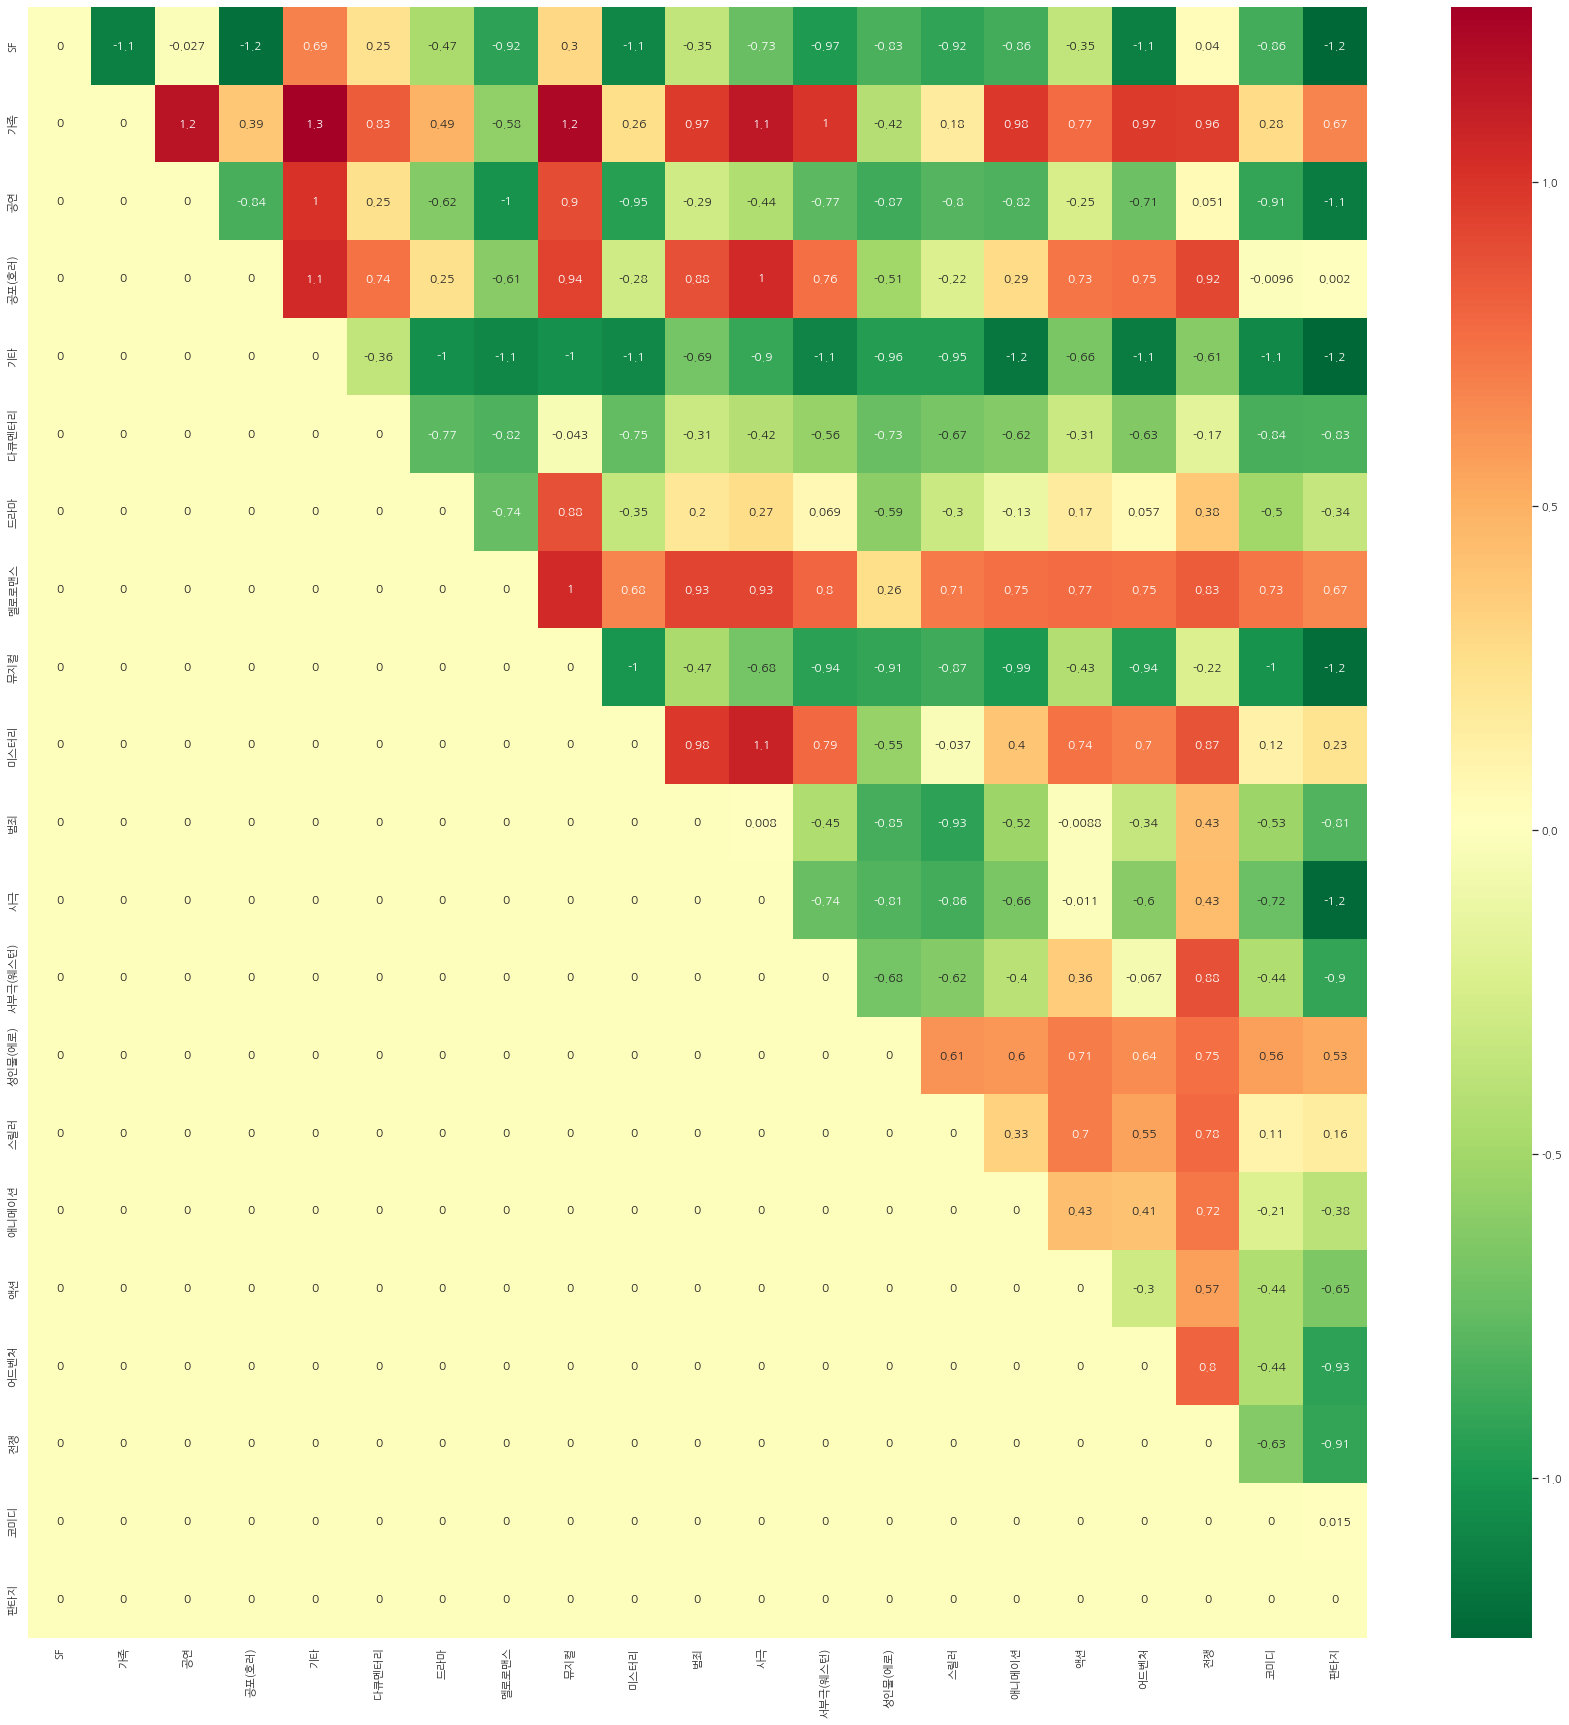

In [33]:
## 히트맵으로 출력
np.random.seed(0)
plt.figure(figsize = (30, 30))

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호
plt.rcParams['axes.unicode_minus'] = False

ax2 = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax2

대표단어의 경우 많이 달라졌지만, WEAT 시각화 통한 결과적으로 보아서는 큰 차이를 보이지는 않는다.

&nbsp;

### ■ 프로젝트 회고

<hr>

#### 1) 이번 프로젝트에서 '어려웠던 점'

우선, 학습 시간이 오래 걸린다는 점이 조금 답답했었다.

진짜 어려웠던 부분은, WEAT score 관련하여 수식과 연계해서 이해가 잘 안가서

어려워 했던 부분이 있었는데, 다른 교육생들에게 도움을 받아서, 배워서 이해할 수 있었다.



#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

대부분 Lecture Node 를 통해서 공부 하였는데, 가장 중요한 내용인 WEAT score 부분과 시각화 후에

해석하는 부분도 X, Y, A, B 의 관계가 헷갈려서 자꾸 사고회로가 멈추는 현상이 와서 진행을 못했었다.

해당 부분을 다른 교육생들에게 배우고, 그리고 다시 노드를 보면서 차근차근 프로젝트 목표를 이해하고,

여러 도움들 덕분에, 다행히도 학습을 진행할 수 있었기에 마무리 까지 올 수 있었다.

대부분의 시간을 WEAT score ／ 시각화에 대한 해석에 대해서 학습하느라 시간을 보냈다.

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

특별히 더 알아낸 점은 없으나, 모호한 점은 WEAT score 를 통해 편향을 알아본 결과가

실제로도 어느정도 효과있게 반영되었는지를 확인하는 방법도 있었으면 좋을 것 같은데,

여기 나온 수치만으로는 ＂이렇게 나온다＂ 라거나 ＂이렇게 볼 수 있다＂하는 정도에서 끝난다.

정말 시놉시스 말뭉치에 이러한 편향이 어느정도 차이를 갖고 느껴지는지는

본문을 통해 확인을 해 봐야 할 것 같은데, 예술영화, 일반영화 부분도 또 고려를 해야 하니

사람이 이걸 확인하는게 쉽지 않을 것 같다. 

따라서 결과도 차이를 보일 것 같고, 그에 대한 해석 또한 많이 다를 것 같다.

수치적으로 이렇다 하고 해석하는 정도에서 마무리 하는게 맞는 건지 조금 의아한 상태이다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

평가 지표의 대부분은 프로젝트 진행 과정에서 만족하는 내용들이다.

초안에서는 수행하지 않았던, 21개의 장르 구분(A,B)에 따른 중복 단어 제거를 수행하였으나,

기본적으로는 예술／일반 영화 구분(X,Y) 에서의 중복 단어 제거의 효과만으로도 충분했음을 확인 하였다.

따라서, 특별히 추가로 시도한 내용은 없고, 전반적인 내용 이해하는 것을 목표로 시간을 투자했다.

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

WEAT score 에 대한 이해와는 별개로, 학습/실습 노드의 내용을 적절히 적용하면

어렵지 않게, 프로젝트는 완성 가능한 내용이라고 생각하지만, 설명에 대한 부분이나

WEAT score 시각화 및 해석에 관한 부분은, 전반적인 개념 이해가 반드시 필요하다고 생각한다.

WEAT score 해석에 관한 부분의 경우, 노드 학습 부분에서와 같이, 보편적으로

명확(꽃 vs 곤충, 유쾌 vs 불쾌) 하게 구분 가능한 주제가 아니다 보니 내용 이해가 충분하지 않다면

루브릭 달성 과정에 어려움이 있을 수 있다.

다만, 평가 지표가 수치화 해서 판단하기 어려운 부분이 있고, 어느정도 주관에 따라

달라질 수 있는 요소가 있을 수 있다고 생각한다.

따라서, 꼼꼼하게 학습한 부분들 빠짐없이 확인 해 보고, 해석도 깔끔하게 한다면,

루브릭 평가 지표는 대부분 달성할 수 있지 않을까 생각한다.

#### 6) 자기 다짐

내용도 어렵고 프로젝트도 코드가 점점 복잡해지다보니 현기증이 난다.

이번에도 큰일날 뻔 했다, 하마터면 라이브러리 import 하는 부분 작성하고 마칠 뻔 했다.

수식만 나오면, 수식과 그 이후의 내용들은 머릿속에 들어오질 않아서 멘붕상태가 오고 있다.

아무래도 난 망한것 같다. 점점 더 힘들어 지는것 같다.

주변에서는, 점점 더 쉬워진다 라거나, 심지어, 이런 내용을 먼저 했어야 하는게 아닐까 하는

이야기들도 나오는데, 나는 지금이 더 힘들고 어렵다는 생각이다.

코드 진행도 느려서 시간 부족한데에 더해서, 이것저것 일정에 치이다보니 집중하기 어렵다.

다짐은 커녕, 좀 쉬어야 할 것 같다.

지금도 시간이 늦어서ㅡ 어떻게든 하나라도 마무리는 지어놓아야, 밀려있는 다음 일정이라도

닥치는 대로 할 텐데, 한 건 더 쌓이면 그냥 다 포기하고 내려놓을 것 같다.

포기하지 말고, 일단 에라모르겠다 하더라도 밀린 것들을 어서 해치워야 할 것 같다.

<hr>

## ◎ Reference

- (AIFFEL) Going Deeper (NLP) Node 05. 워드 임베딩


- (AIFFEL) Going Deeper (NLP) Node 06. 임베딩 내 편향성 알아보기

&nbsp;